In [1]:
!git clone "https://github.com/jacksonshaiz/Project2_G9_DS_4001"

Cloning into 'Project2_G9_DS_4001'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 144 (delta 52), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (144/144), 804.05 KiB | 10.31 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [ ]:
!rm -rf repo

In [49]:
import pandas as pd
import yfinance as yf
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

/tmp/ipython-input-1026312274.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period, interval=interval)
[*********************100%***********************]  10 of 10 completed


✅ Saved: historical_prices_3mo.csv


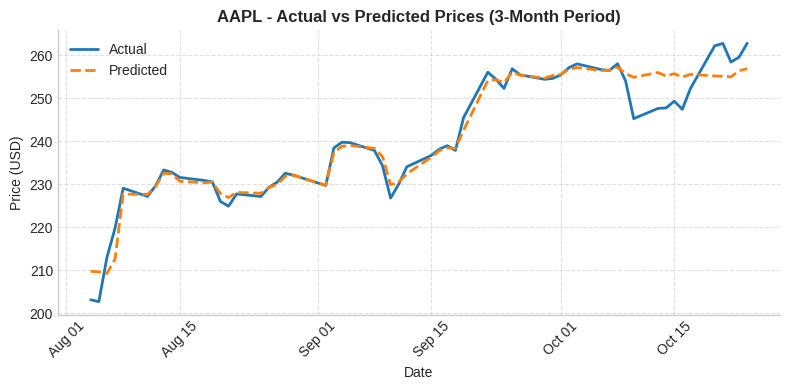

AAPL → Last Actual: 262.82, Predicted Next: 256.91



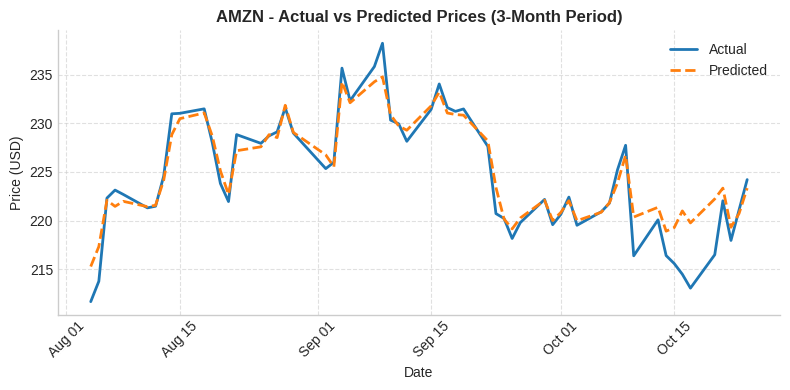

AMZN → Last Actual: 224.21, Predicted Next: 223.33



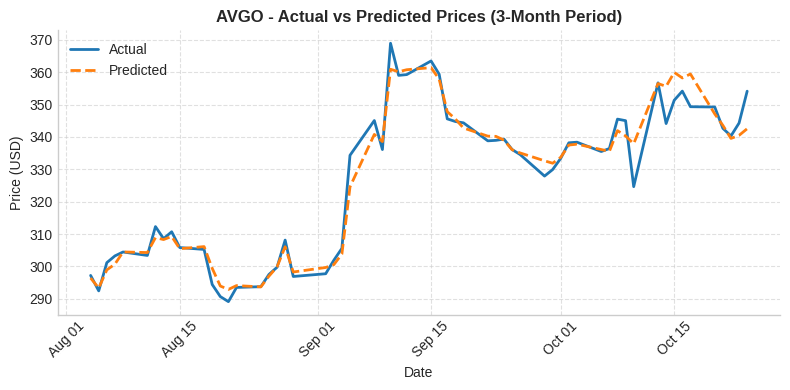

AVGO → Last Actual: 354.13, Predicted Next: 342.54



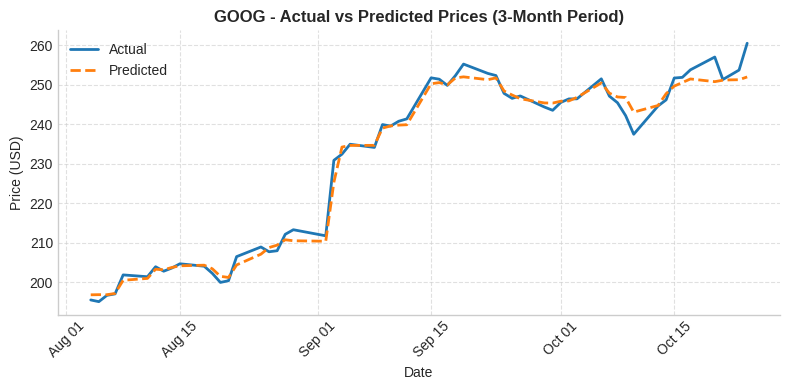

GOOG → Last Actual: 260.51, Predicted Next: 251.99



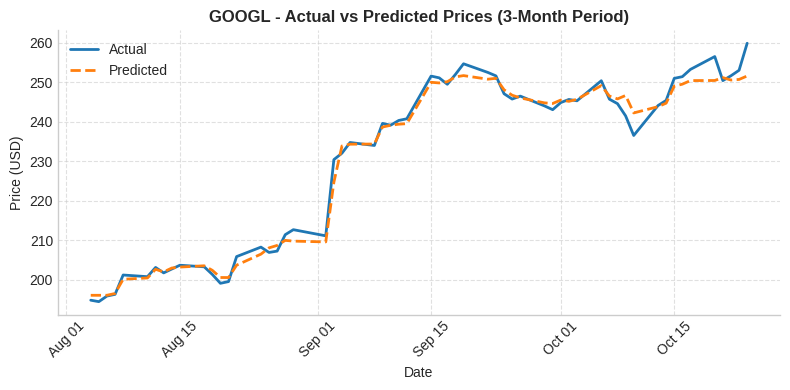

GOOGL → Last Actual: 259.92, Predicted Next: 251.64



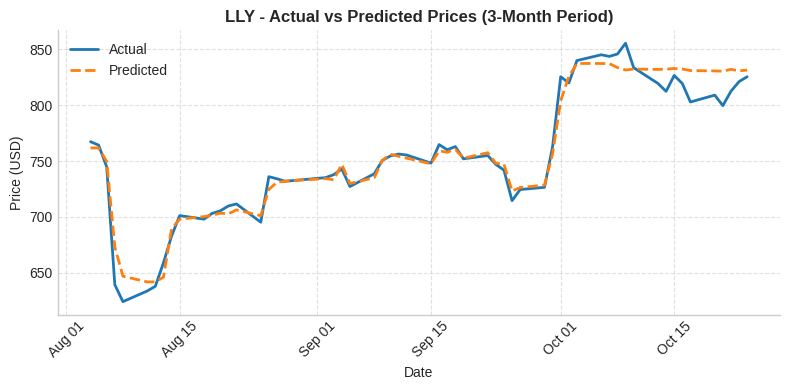

LLY → Last Actual: 825.45, Predicted Next: 831.40



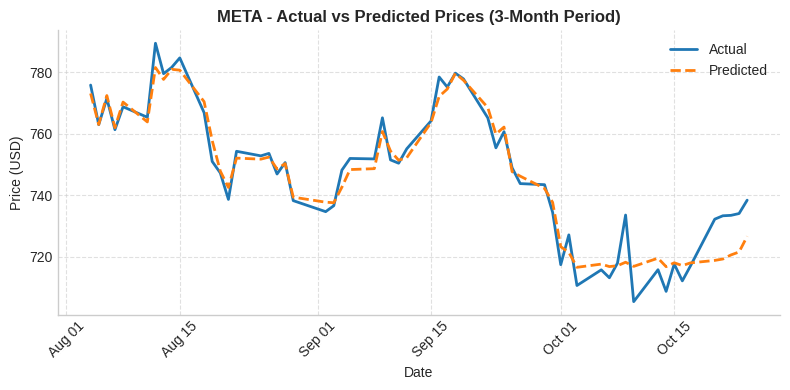

META → Last Actual: 738.36, Predicted Next: 726.57



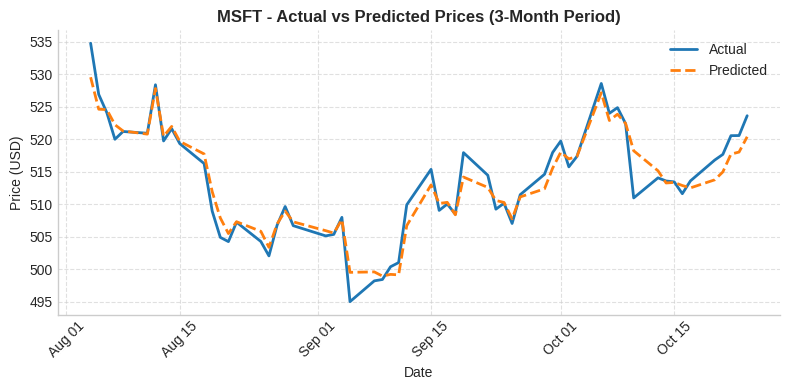

MSFT → Last Actual: 523.61, Predicted Next: 520.37



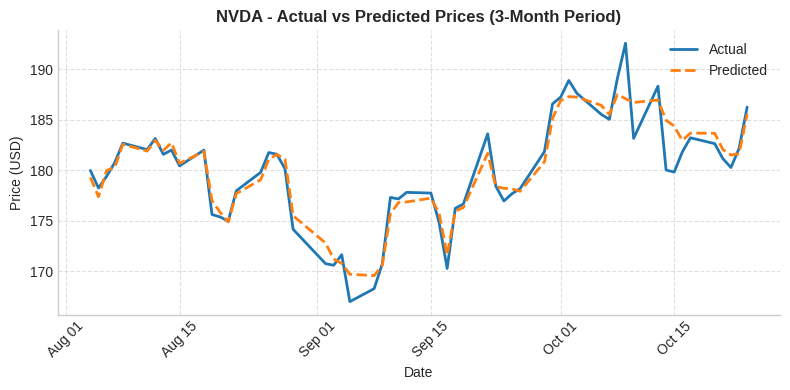

NVDA → Last Actual: 186.26, Predicted Next: 185.57



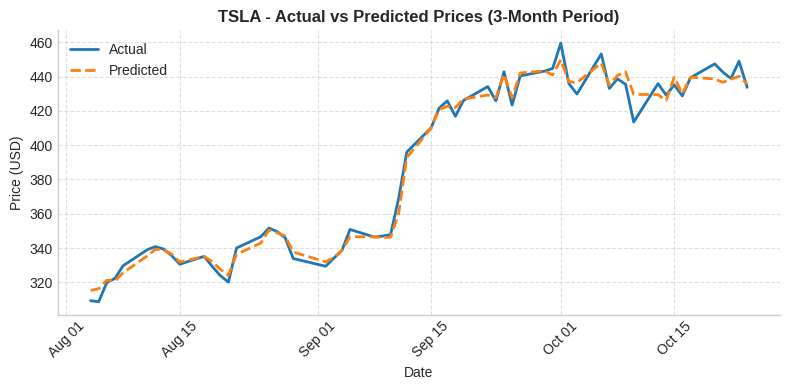

TSLA → Last Actual: 433.72, Predicted Next: 435.73

✅ Saved: model_performance_summary.csv

Model Performance Summary:
   Ticker        R²         MSE        MAE
0   AAPL  0.006767   41.059547   5.956655
1   AMZN  0.208670   13.627761   2.948739
2   AVGO  0.156449   56.478141   5.972171
3   GOOG  0.599938   15.413447   3.014063
4  GOOGL  0.602773   15.658958   3.090272
5    LLY -0.647489  337.097303  16.021506
6   META  0.136633  109.499830   9.148004
7   MSFT  0.524809    8.184823   2.120274
8   NVDA  0.405396    7.929445   2.155052
9   TSLA  0.403670   48.345210   5.424223
✅ Saved: 3month_features_with_lags.csv
Ticker       Date       Close    Return     lag_1     lag_2     lag_3  \
0      2025-08-04  203.119492  0.004793 -0.025004 -0.007080 -0.010508   
1      2025-08-05  202.689957 -0.002115  0.004793 -0.025004 -0.007080   
2      2025-08-06  213.008255  0.050907 -0.002115  0.004793 -0.025004   
3      2025-08-07  219.780563  0.031794  0.050907 -0.002115  0.004793   
4      2025-08

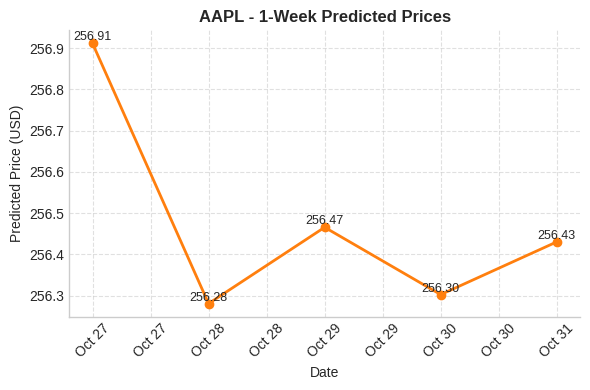

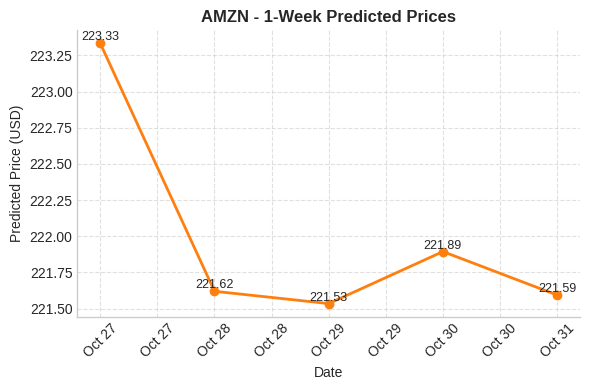

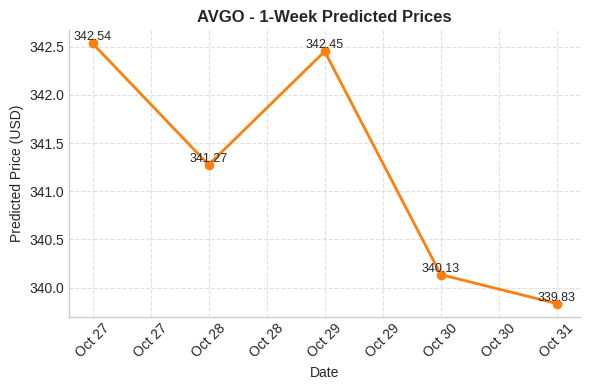

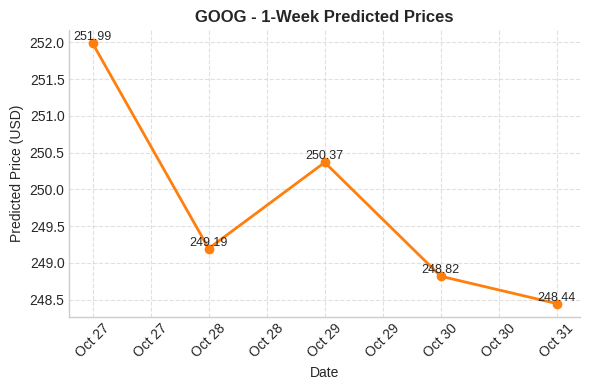

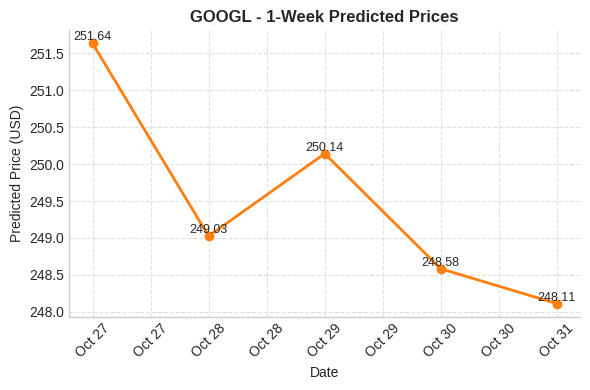

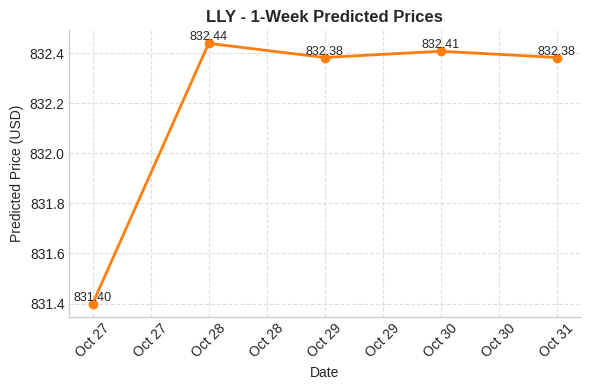

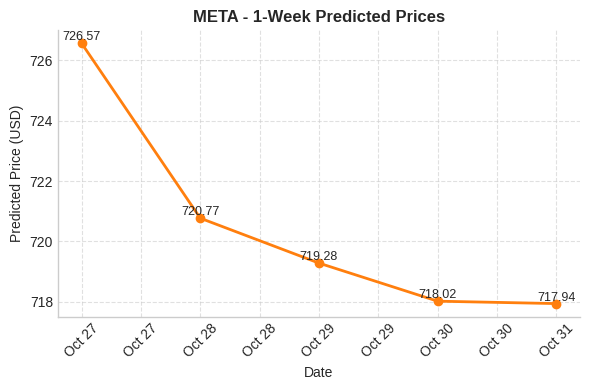

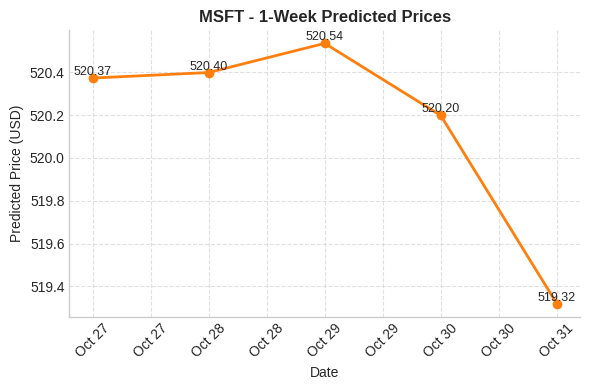

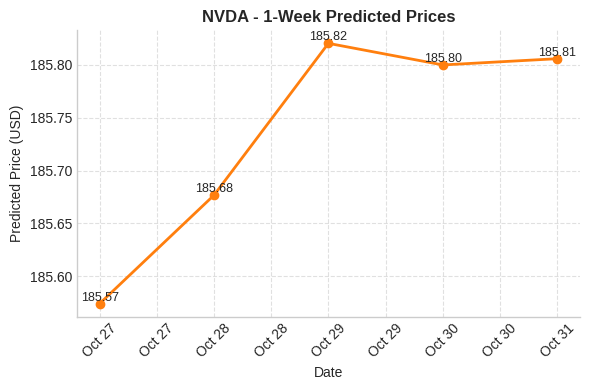

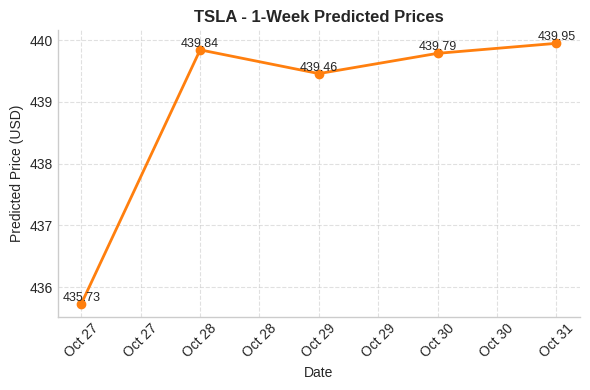

In [50]:

plt.style.use("seaborn-v0_8-whitegrid")  # clean plot style

# --- SETTINGS ---
tickers = ["AAPL", "AMZN", "AVGO", "GOOG", "GOOGL", "LLY", "META", "MSFT", "NVDA", "TSLA"]
period = "3mo"
interval = "1d"

# --- DOWNLOAD DATA ---
data = yf.download(tickers, period=period, interval=interval)
close_prices = data["Close"]

# Save raw historical data to CSV
close_prices.to_csv("historical_prices_3mo.csv")
print("✅ Saved: historical_prices_3mo.csv")

# --- FEATURE ENGINEERING ---
def create_features(df):
    df = df.copy()
    df["Return"] = df["Close"].pct_change()
    for lag in [1, 2, 3, 5]:
        df[f"lag_{lag}"] = df["Return"].shift(lag)
    df["MA_3"] = df["Close"].rolling(3).mean()
    df["MA_5"] = df["Close"].rolling(5).mean()
    df["Volatility_5"] = df["Return"].rolling(5).std()
    df.dropna(inplace=True)
    return df

# --- MODEL TRAINING ---
results = []
future_forecasts = {}  # store 1-week predictions
all_features = []      # to collect feature data for CSV

for ticker in tickers:
    df = close_prices[[ticker]].reset_index()
    df.rename(columns={ticker: "Close"}, inplace=True)

    # Create features
    df = create_features(df)

    # Add ticker column for CSV
    df["Ticker"] = ticker
    all_features.append(df)  # store engineered data

    # Prepare data for model
    X = df.drop(columns=["Close", "Date", "Ticker"])
    y = df["Close"]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Random Forest model
    model = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=8, min_samples_split=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    results.append({"Ticker": ticker, "R²": r2, "MSE": mse, "MAE": mae})

    # --- Plot Actual vs Predicted ---
    y_pred_all = model.predict(X)
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(df["Date"], y, label="Actual", color="#1f77b4", linewidth=2)
    ax.plot(df["Date"], y_pred_all, label="Predicted", color="#ff7f0e", linestyle="--", linewidth=2)
    ax.set_title(f"{ticker} - Actual vs Predicted Prices (3-Month Period)", fontsize=12, weight="bold")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price (USD)")
    ax.legend(frameon=False)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.xaxis.set_major_formatter(DateFormatter("%b %d"))
    ax.xaxis.set_major_locator(AutoDateLocator())
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- Predict Next-Day Price ---
    last_row = X.iloc[[-1]]
    next_pred = model.predict(last_row)[0]
    last_actual = df["Close"].iloc[-1]
    print(f"{ticker} → Last Actual: {last_actual:.2f}, Predicted Next: {next_pred:.2f}\n")

    # --- Predict Next Week (5 trading days) ---
    last_features = X.iloc[[-1]].copy()
    last_close = df["Close"].iloc[-1]
    preds = []
    closes = [last_close]

    for i in range(5):
        next_close = model.predict(last_features)[0]
        preds.append(next_close)
        closes.append(next_close)

        returns = pd.Series(np.diff(closes) / closes[:-1])
        lag_1 = returns.iloc[-1] if len(returns) > 0 else 0
        lag_2 = returns.iloc[-2] if len(returns) > 1 else 0
        lag_3 = returns.iloc[-3] if len(returns) > 2 else 0
        lag_5 = returns.iloc[-5] if len(returns) > 4 else 0
        ma_3 = np.mean(closes[-3:]) if len(closes) >= 3 else np.mean(closes)
        ma_5 = np.mean(closes[-5:]) if len(closes) >= 5 else np.mean(closes)
        vol_5 = np.std(returns.iloc[-5:]) if len(returns) >= 5 else np.std(returns)

        last_features = pd.DataFrame({
            "Return": [lag_1],
            "lag_1": [lag_1],
            "lag_2": [lag_2],
            "lag_3": [lag_3],
            "lag_5": [lag_5],
            "MA_3": [ma_3],
            "MA_5": [ma_5],
            "Volatility_5": [vol_5]
        })

    future_dates = pd.date_range(start=df["Date"].iloc[-1] + pd.Timedelta(days=1), periods=5, freq="B")
    forecast_df = pd.DataFrame({"Date": future_dates, "Predicted_Close": preds})
    future_forecasts[ticker] = forecast_df


# --- RESULTS SUMMARY ---
results_df = pd.DataFrame(results)
results_df.to_csv("model_performance_summary.csv", index=False)
print("✅ Saved: model_performance_summary.csv")
print("\nModel Performance Summary:\n", results_df)

# --- SAVE ENGINEERED FEATURES CSV ---
combined_df = pd.concat(all_features, ignore_index=True)
combined_df.to_csv("3month_features_with_lags.csv", index=False)
print("✅ Saved: 3month_features_with_lags.csv")

# --- PREVIEW ---
print(combined_df.head())

# --- 1-WEEK FORECAST GRAPHS ---
for ticker, forecast_df in future_forecasts.items():
    fig, ax = plt.subplots(figsize=(6, 4))

    # Plot predicted prices
    ax.plot(forecast_df["Date"], forecast_df["Predicted_Close"], marker="o", color="#ff7f0e", linewidth=2)

    # Add points labels
    for x, y in zip(forecast_df["Date"], forecast_df["Predicted_Close"]):
        ax.text(x, y, f"{y:.2f}", ha="center", va="bottom", fontsize=9)

    # Titles and labels
    ax.set_title(f"{ticker} - 1-Week Predicted Prices", fontsize=12, weight="bold")
    ax.set_xlabel("Date")
    ax.set_ylabel("Predicted Price (USD)")

    # Formatting
    ax.xaxis.set_major_formatter(DateFormatter("%b %d"))
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

📊 Model Performance Summary Table:


,Ticker,R²,MSE,MAE
0,AAPL,0.006767,41.059547,5.956655
1,AMZN,0.208670,13.627761,2.948739
2,AVGO,0.156449,56.478141,5.972171
3,GOOG,0.599938,15.413447,3.014063
4,GOOGL,0.602773,15.658958,3.090272
5,LLY,-0.647489,337.097303,16.021506
6,META,0.136633,109.499830,9.148004
7,MSFT,0.524809,8.184823,2.120274
8,NVDA,0.405396,7.929445,2.155052
9,TSLA,0.403670,48.345210,5.424223


/tmp/ipython-input-1914349142.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Ticker", y=metric, data=results_df, ax=ax, palette=[color]*len(results_df))
/tmp/ipython-input-1914349142.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Ticker", y=metric, data=results_df, ax=ax, palette=[color]*len(results_df))
/tmp/ipython-input-1914349142.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Ticker", y=metric, data=results_df, ax=ax, palette=[color]*len(results_df))


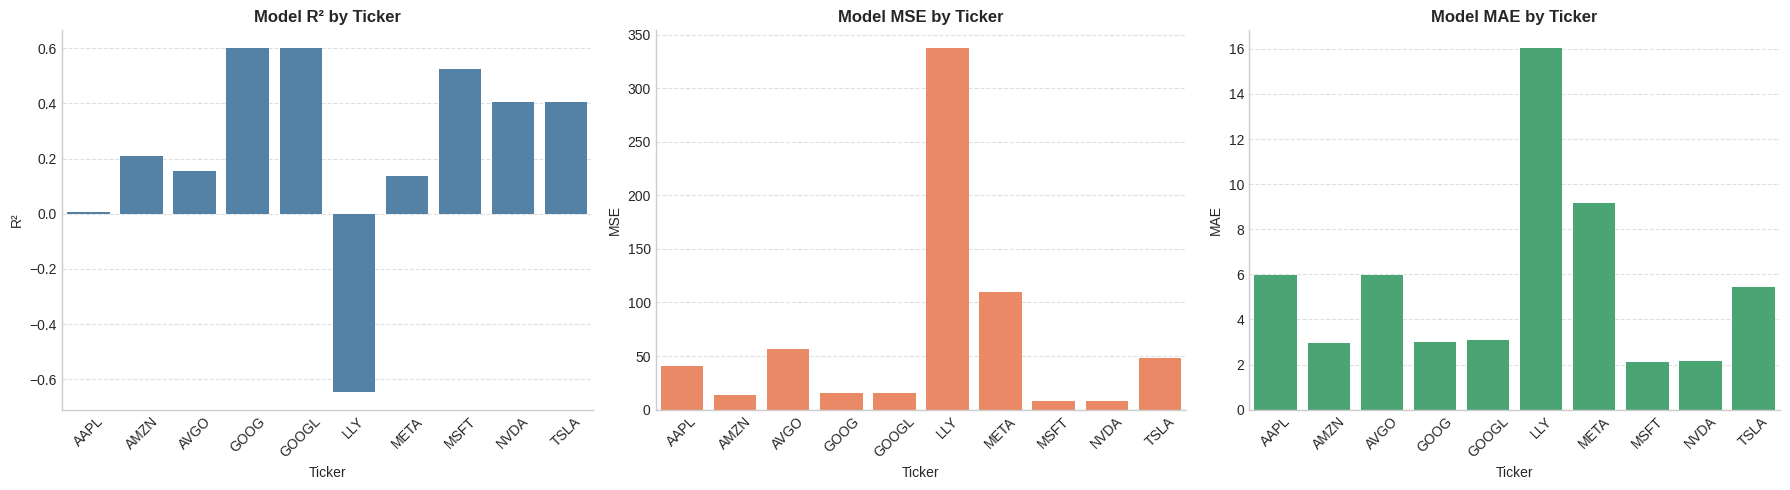

In [47]:

# --- Table of metrics ---
print("📊 Model Performance Summary Table:")
display(results_df)  # if using Jupyter/Colab, this will render a nice table

# --- Bar plots for each metric ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics = ["R²", "MSE", "MAE"]
colors = ["steelblue", "coral", "mediumseagreen"]

for ax, metric, color in zip(axes, metrics, colors):
    sns.barplot(x="Ticker", y=metric, data=results_df, ax=ax, palette=[color]*len(results_df))
    ax.set_title(f"Model {metric} by Ticker", fontsize=12, weight="bold")
    ax.set_xlabel("Ticker")
    ax.set_ylabel(metric)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

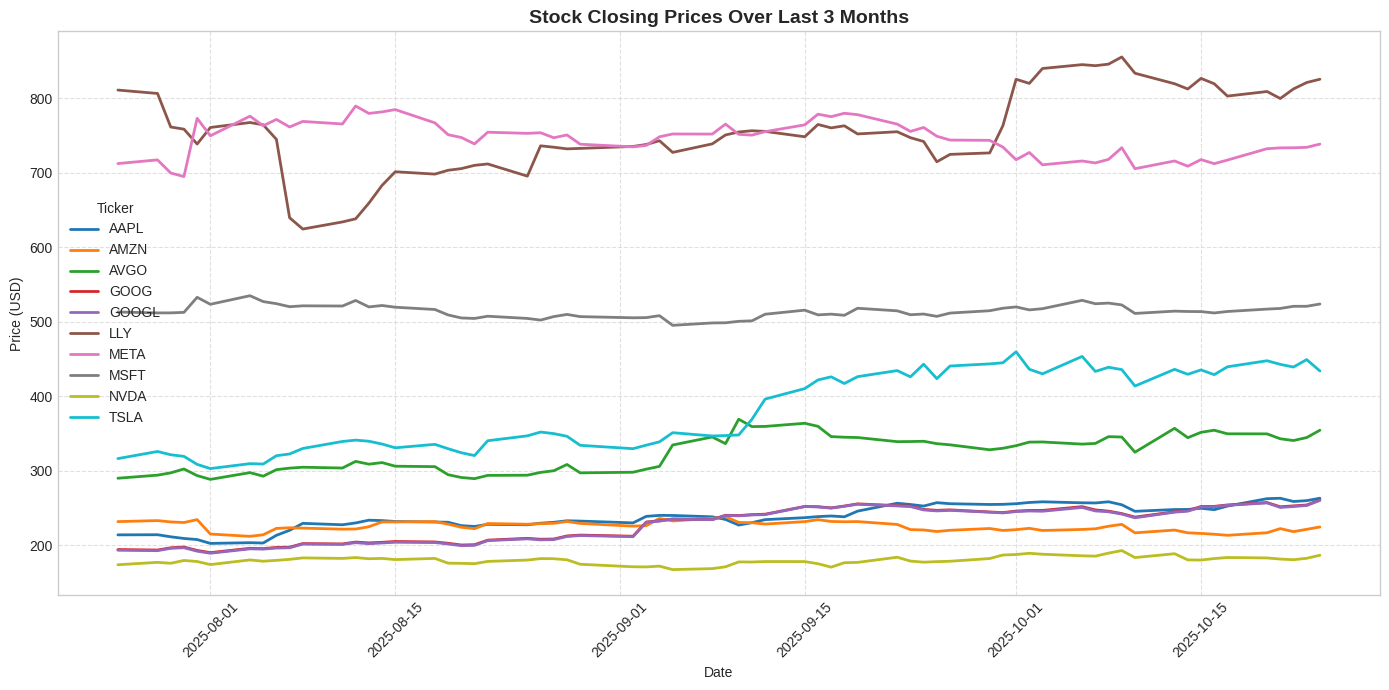

In [53]:
# --- EDA-Price Change  ---
plt.figure(figsize=(14, 7))

for ticker in tickers:
    plt.plot(close_prices.index, close_prices[ticker], label=ticker, linewidth=2)

plt.title("Stock Closing Prices Over Last 3 Months", fontsize=14, weight="bold")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend(title="Ticker")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



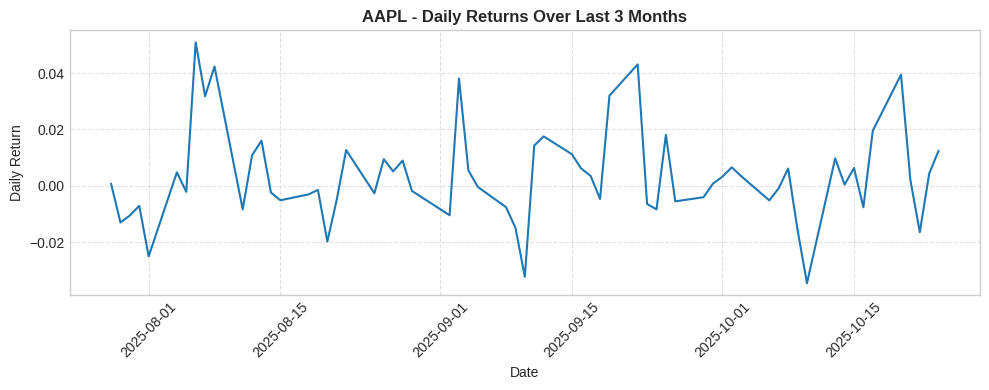

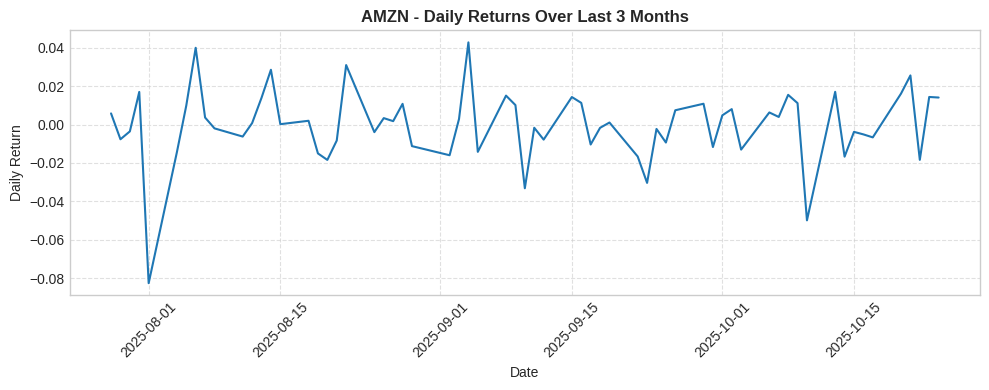

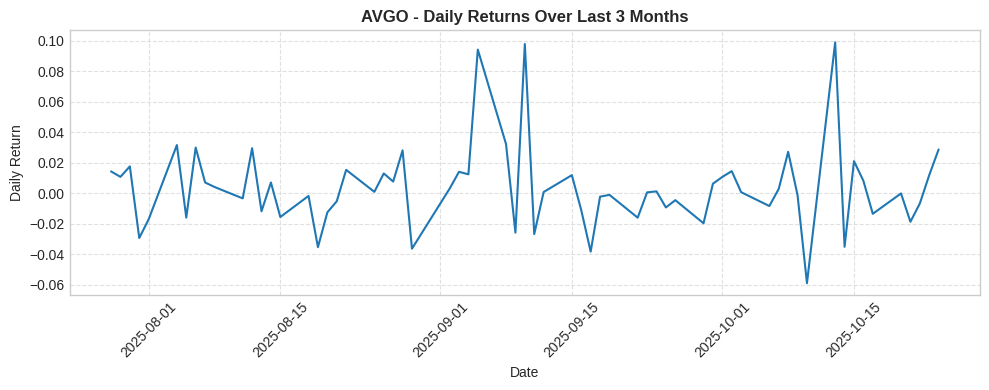

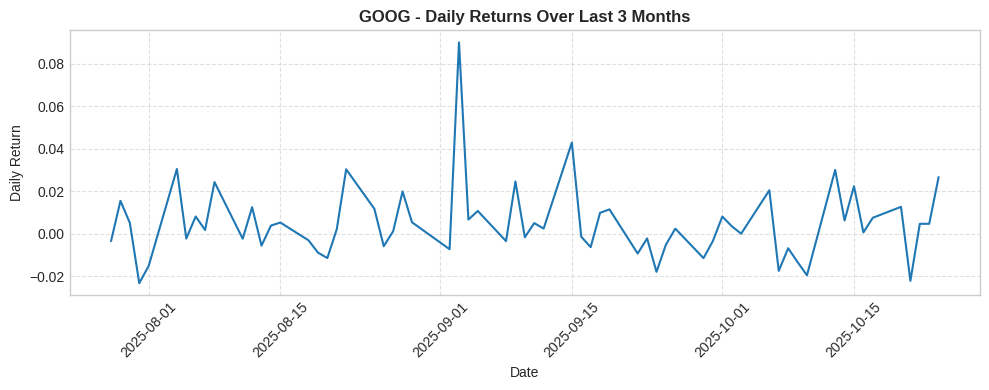

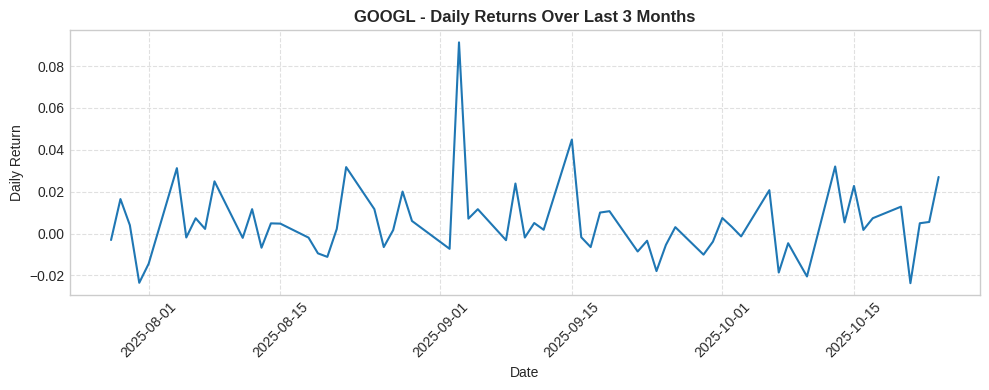

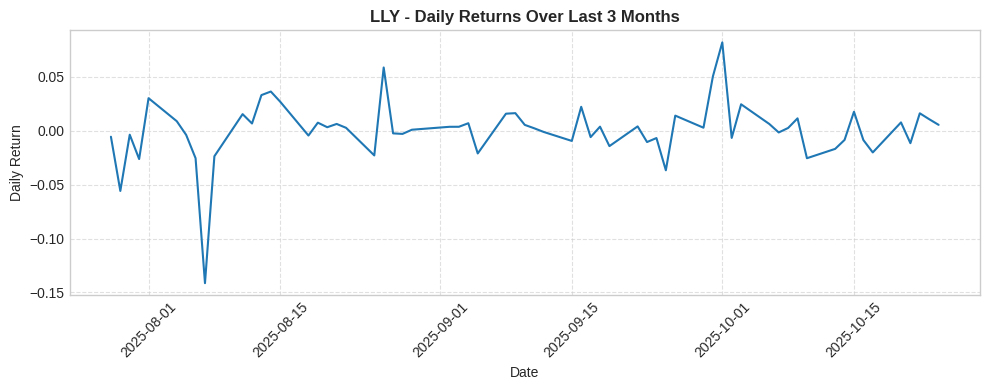

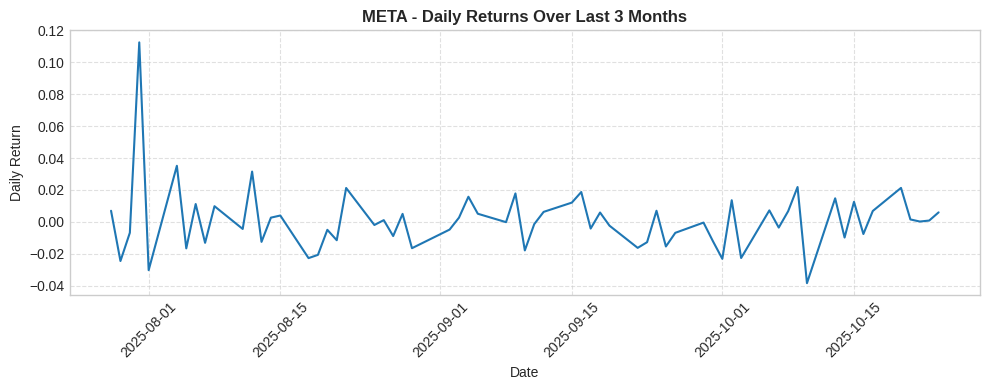

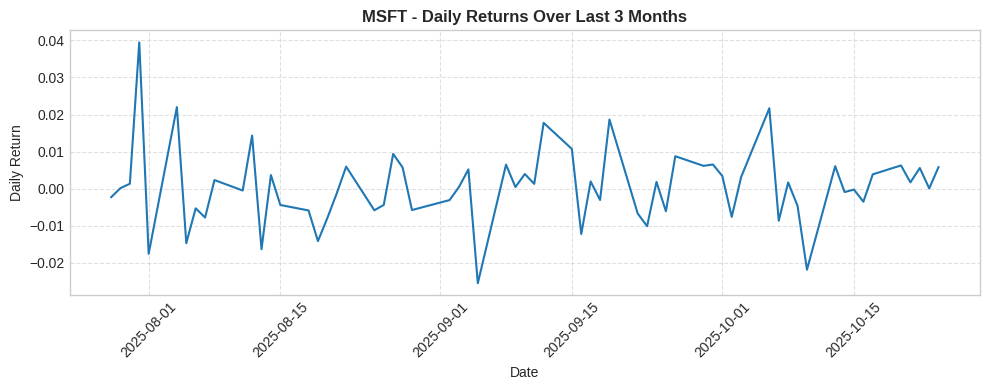

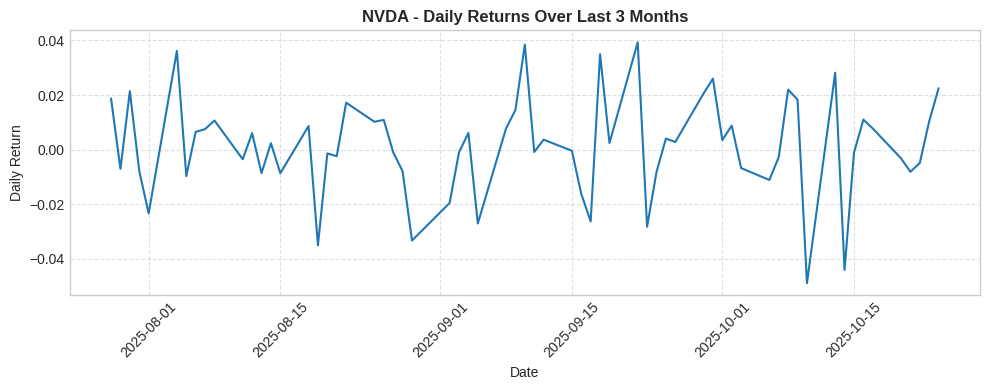

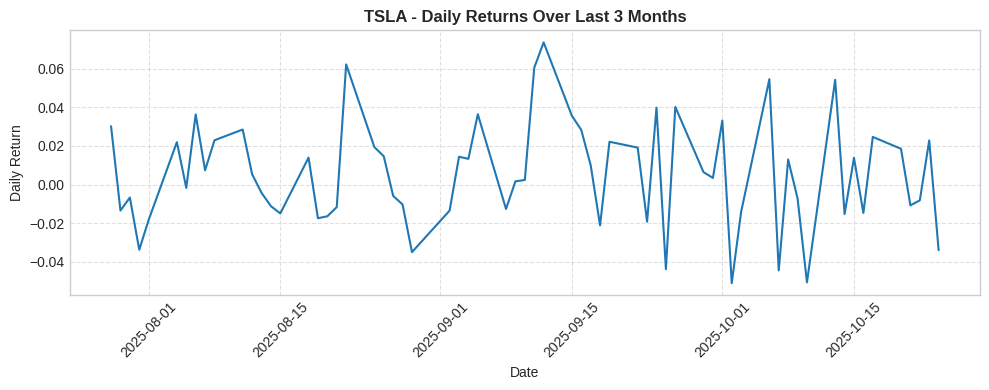

In [55]:
# --- INDIVIDUAL DAILY RETURN GRAPHS ---
daily_returns = close_prices.pct_change().dropna()  # percentage change, drop first NaN row

for ticker in tickers:
    plt.figure(figsize=(10, 4))
    plt.plot(daily_returns.index, daily_returns[ticker], color="#1f77b4", linewidth=1.5)
    plt.title(f"{ticker} - Daily Returns Over Last 3 Months", fontsize=12, weight="bold")
    plt.xlabel("Date")
    plt.ylabel("Daily Return")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

